In [ ]:
!pip install pandas scipy scikit-learn cupy-cuda101 livelossplot numba

In [1]:
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split

from bprH_gpu import bprH

%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_csv("data/Sobazaar-bprh-cleaned.csv")

In [3]:
# Here we only consider data with View
data = data[~(data.Action == "L")]
data.reset_index(inplace=True, drop=True)
data.drop_duplicates(inplace=True)

In [4]:
# we select user wo have purchased at least 4 items
user_filter = data[data.Action == "P"].groupby("UserID").count().ItemID
data_more2 = data[data.UserID.isin(user_filter[user_filter >= 2].index.tolist())]
data_only1 = data[data.UserID.isin(user_filter[user_filter < 2].index.tolist())]
# what if we add those users with less 4 purchases into train data?
# TODO

In [5]:
data_without_target = data_more2[data_more2.Action != 'P']
data_only_with_target = data_more2[data_more2.Action == 'P']

In [6]:
d1, test_data = train_test_split(data_only_with_target,
                                 test_size=0.2,
                                 random_state=20200717
                                 )

train_data = pd.concat([d1, data_without_target, data_only1])
train_data.reset_index(inplace=True,drop=True)
test_data.reset_index(inplace=True,drop=True)

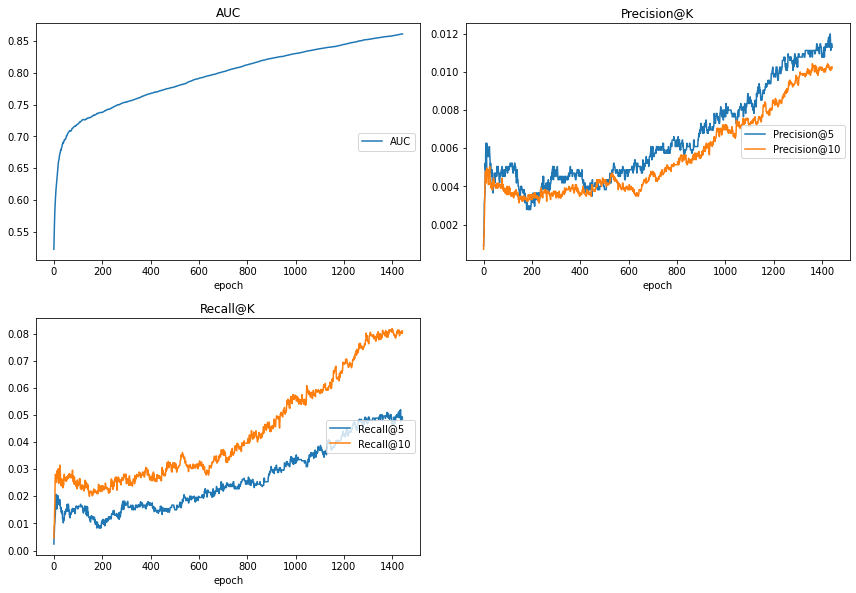

 60%|██████    | 865803/1440000 [18:04:49<149:39:35,  1.07it/s, est_changed=1.565613332547801, len_I=2, len_J=1, len_K=5]   

AUC
	AUC              	 (min:    0.523, max:    0.861, cur:    0.861)
Precision@K
	Precision@5      	 (min:    0.001, max:    0.012, cur:    0.011)
	Precision@10     	 (min:    0.001, max:    0.010, cur:    0.010)
Recall@K
	Recall@5         	 (min:    0.002, max:    0.052, cur:    0.049)
	Recall@10        	 (min:    0.005, max:    0.082, cur:    0.081)


 60%|██████    | 866397/1440000 [18:05:16<7:13:29, 22.05it/s, est_changed=10.575656091376153, len_I=2, len_J=1, len_K=1]    

In [ ]:
bprh_model = bprH(dim=50,
                  omega=3000,
                  rho=1,
                  lambda_u=0.000005,
                  lambda_v=0.000005,
                  lambda_b=0.000005,
                  gamma=0.1,
                  random_state=20200717,
                  num_iter=180000*8,
                  existed_model_path=None)

bprh_model.fit(X=train_data,
               eval_X=test_data,
               model_saved_path="bprh_soba_0718_filtered5.pkl",
               correlation=True,
               coselection=True,
               plot_metric=True,
               log_metric=True,
               iter_to_log=600,
               iter_to_save=480000)

In [ ]:
scoring_list, p, r, auc = bprh_model.scoring(ground_truth=bprh_model.test_data,
                                      K=10,
                                      train_data_as_reference_flag=True)
print('Recall: test %.4f.' % r)
print('Precision: test %.4f.' % p)
print('AUC: test %.4f.' % auc)

In [ ]:
scoring_list, p, r, auc = bprh_model.scoring(ground_truth=bprh_model.train_data,
                                      K=10,
                                      train_data_as_reference_flag=False)
print('Recall: train %.4f.' % r)
print('Precision: train %.4f.' % p)
print('AUC: train %.4f.' % auc)